# Data Cleansing

## In this notebook

The data cleansing process involves two main steps:

1. Detecting outliers - using statistical methods such as Z-Score and IQR
2. Filling missing data - either with constant values (e.g., mean) or by using a smart unsupervised model approach

It is important to first detect outliers and only then deal with the missing data, since outliers will be set to null.

I will use IQR for outliers detection and the MICE imputation for filling missing data.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_pickle("./pickle/01_data_preparation/data_preparation.pkl")

## Outliers detection

First lets have a visual representation of the outliers using Box Plots:

In [3]:
# Select only numerical columns (int, float, and optionally bool)
df_num = df.select_dtypes(include=["number"]).copy()

# Drop the dummy columns
df_num = df_num.drop(columns=['mode', 'edm', 'latin', 'pop', 'r&b', 'rap', 'rock','playlist_count'])

con_col = df_num.columns

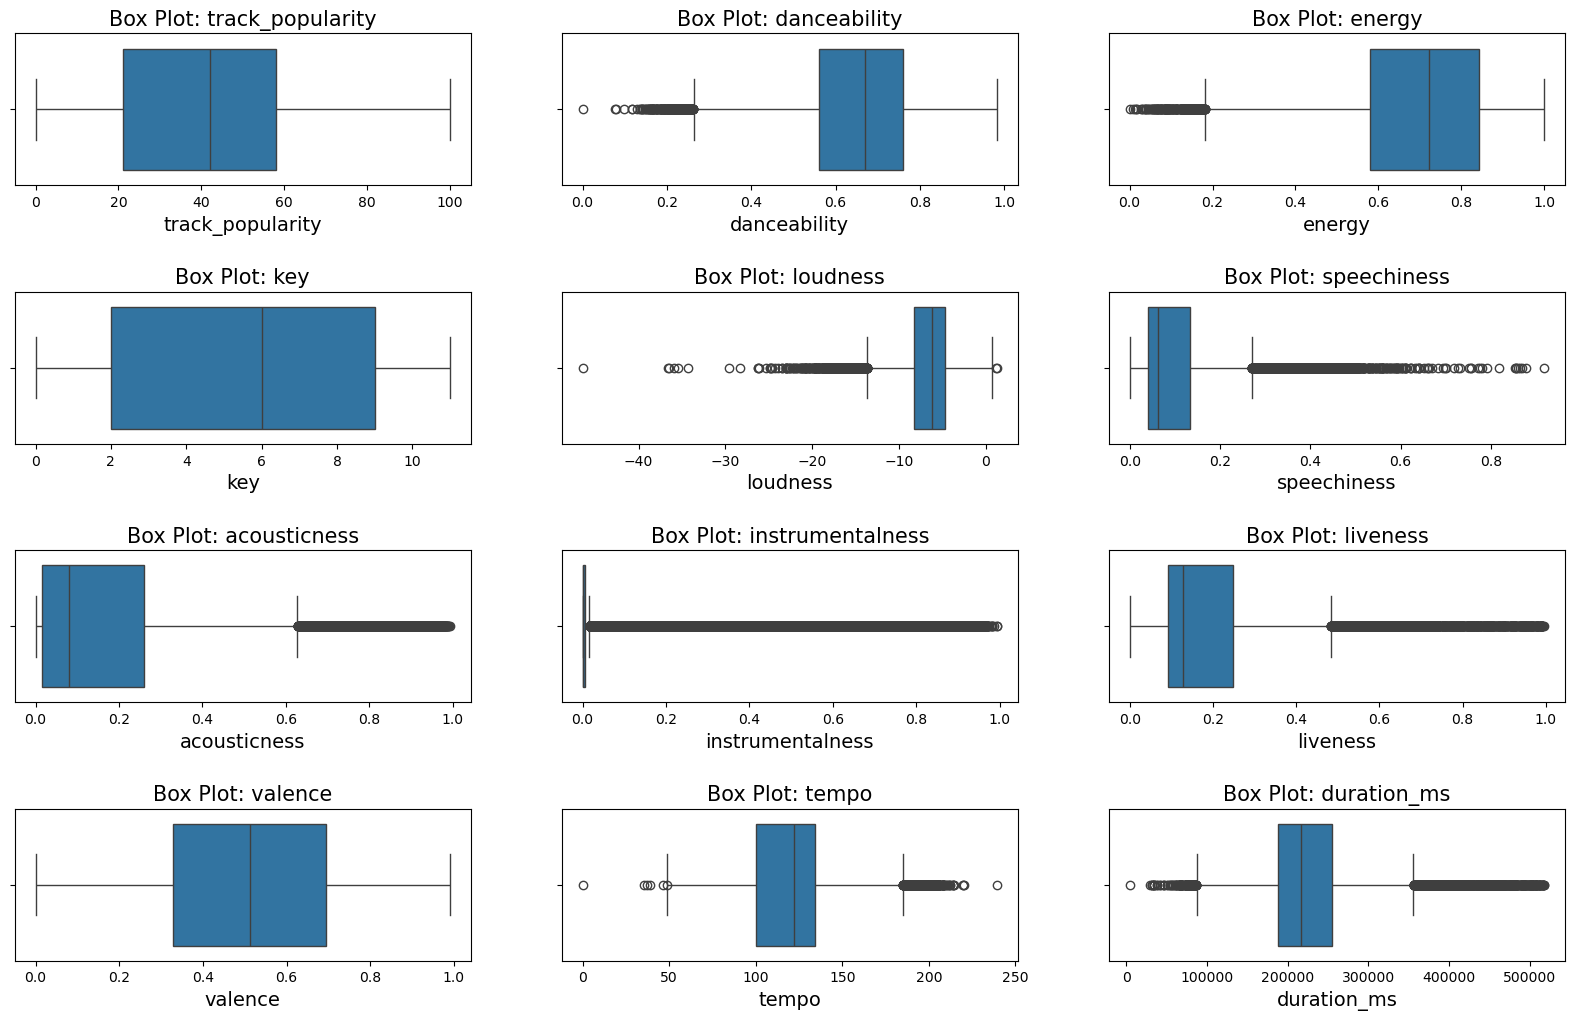

In [4]:
## Using box (Wiskers) plot 
plt.figure(figsize=(20,200))

def outliers_boxplot(df_num):
    for i, col in enumerate(df_num.columns):
        
            ax = plt.subplot(60, 3, i+1)
            sns.boxplot(data=df_num, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)
        
outliers_boxplot(df_num)
plt.show()

### Using IQR score to determine outliers

It is important to label outlier values based on a designated metric and not just by relying on a visual tool.

In this project I decided to use the IQR method for finding outlier values. I will set lower and upper bound from the IQR value, computed by: $IQR = Q3 - Q1$. All values outside those bounds will be set to Null.

First, lets see how many outlier values we have in each column:

In [5]:
def get_outliers_df(df):
    total_outliers = pd.DataFrame(columns=['Outlier count', 'Percent'])

    for col in df.columns:  # Ensure processing numeric columns only
        temp = pd.DataFrame(df[col])
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        # Filter rows that are outliers in either direction
        temp_outliers = temp[(temp[col] > upper_limit) | (temp[col] < lower_limit)]
        num_outliers = len(temp_outliers)
        total_outliers.loc[col] = [num_outliers, num_outliers / len(df) * 100]

    return total_outliers[total_outliers['Percent'] > 0]

# Assume con_df is your DataFrame
# Call the function and sort results
outliers_df = get_outliers_df(df_num).sort_values('Percent', ascending=False)
outliers_df

,Outlier count,Percent
instrumentalness,6085.0,21.459303
speechiness,2725.0,9.609959
acousticness,1911.0,6.739314
liveness,1623.0,5.723656
duration_ms,1197.0,4.221329
loudness,837.0,2.951756
tempo,494.0,1.742136
danceability,257.0,0.906334
energy,222.0,0.782903


#### Set outilers to `NaN`

In [6]:
def replace_outliers_with_nan(df):
    label_out_df = df.copy()
    outliers_df_result = get_outliers_df(df)  # Call the outliers_df function
    for col in label_out_df:
        if col in outliers_df_result.index:
            Q1 = label_out_df[col].quantile(0.25)
            Q3 = label_out_df[col].quantile(0.75)
            IQR = Q3 - Q1
            upper_limit = Q1 + 1.5 * IQR
            lower_limit = Q3 - 1.5 * IQR
            label_out_df[col] = np.where((label_out_df[col] > upper_limit) | (label_out_df[col] < lower_limit), np.nan, label_out_df[col])
    return label_out_df

# Example usage
# Assume df is your DataFrame
df_num_nan = replace_outliers_with_nan(df_num)
display(df_num_nan.shape)
df_num_nan.head(10)

(28356, 12)

,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,41,0.682,NaN,2,-10.068,0.0236,0.279000,NaN,0.0887,0.566,97.091,235440.0
1,15,0.582,0.704,5,-6.242,0.0347,0.065100,0.000000,0.2120,0.698,150.863,197286.0
2,28,NaN,0.880,9,-4.739,0.0442,0.011700,NaN,NaN,0.404,135.225,NaN
3,24,0.659,0.794,10,-5.644,0.0540,0.000761,NaN,0.3220,0.852,128.041,228565.0
4,38,0.662,0.838,1,-6.300,0.0499,0.114000,0.000697,0.0881,0.496,129.884,236308.0
5,12,0.836,0.799,7,-4.247,0.0873,0.187000,0.000000,0.0920,0.772,94.033,217653.0
6,41,NaN,0.616,1,-8.747,NaN,NaN,0.000000,NaN,0.716,145.461,NaN
7,52,0.764,0.594,6,-10.050,NaN,NaN,0.000000,0.1450,0.695,87.261,286441.0
8,36,0.743,0.860,5,-6.346,0.0445,0.226000,0.000422,0.0513,0.687,102.459,259267.0
9,42,0.573,0.746,10,-4.894,0.0421,0.024900,0.000000,NaN,0.134,130.001,188000.0


## Missing Values Imputation

The next step in our data cleansing task will be to fill the missing values.

I will be using **MICE - Multiple Imputation by Chained Equations**, a data imputation technique which uses regression model to predict missing values. MICE is the most relevant technique here since we are dealing with missing continuous values, and there are other continuous features that can be used as predictors for the regression.

But first, lets visualize the missing values in each column - using the `missingno` package:

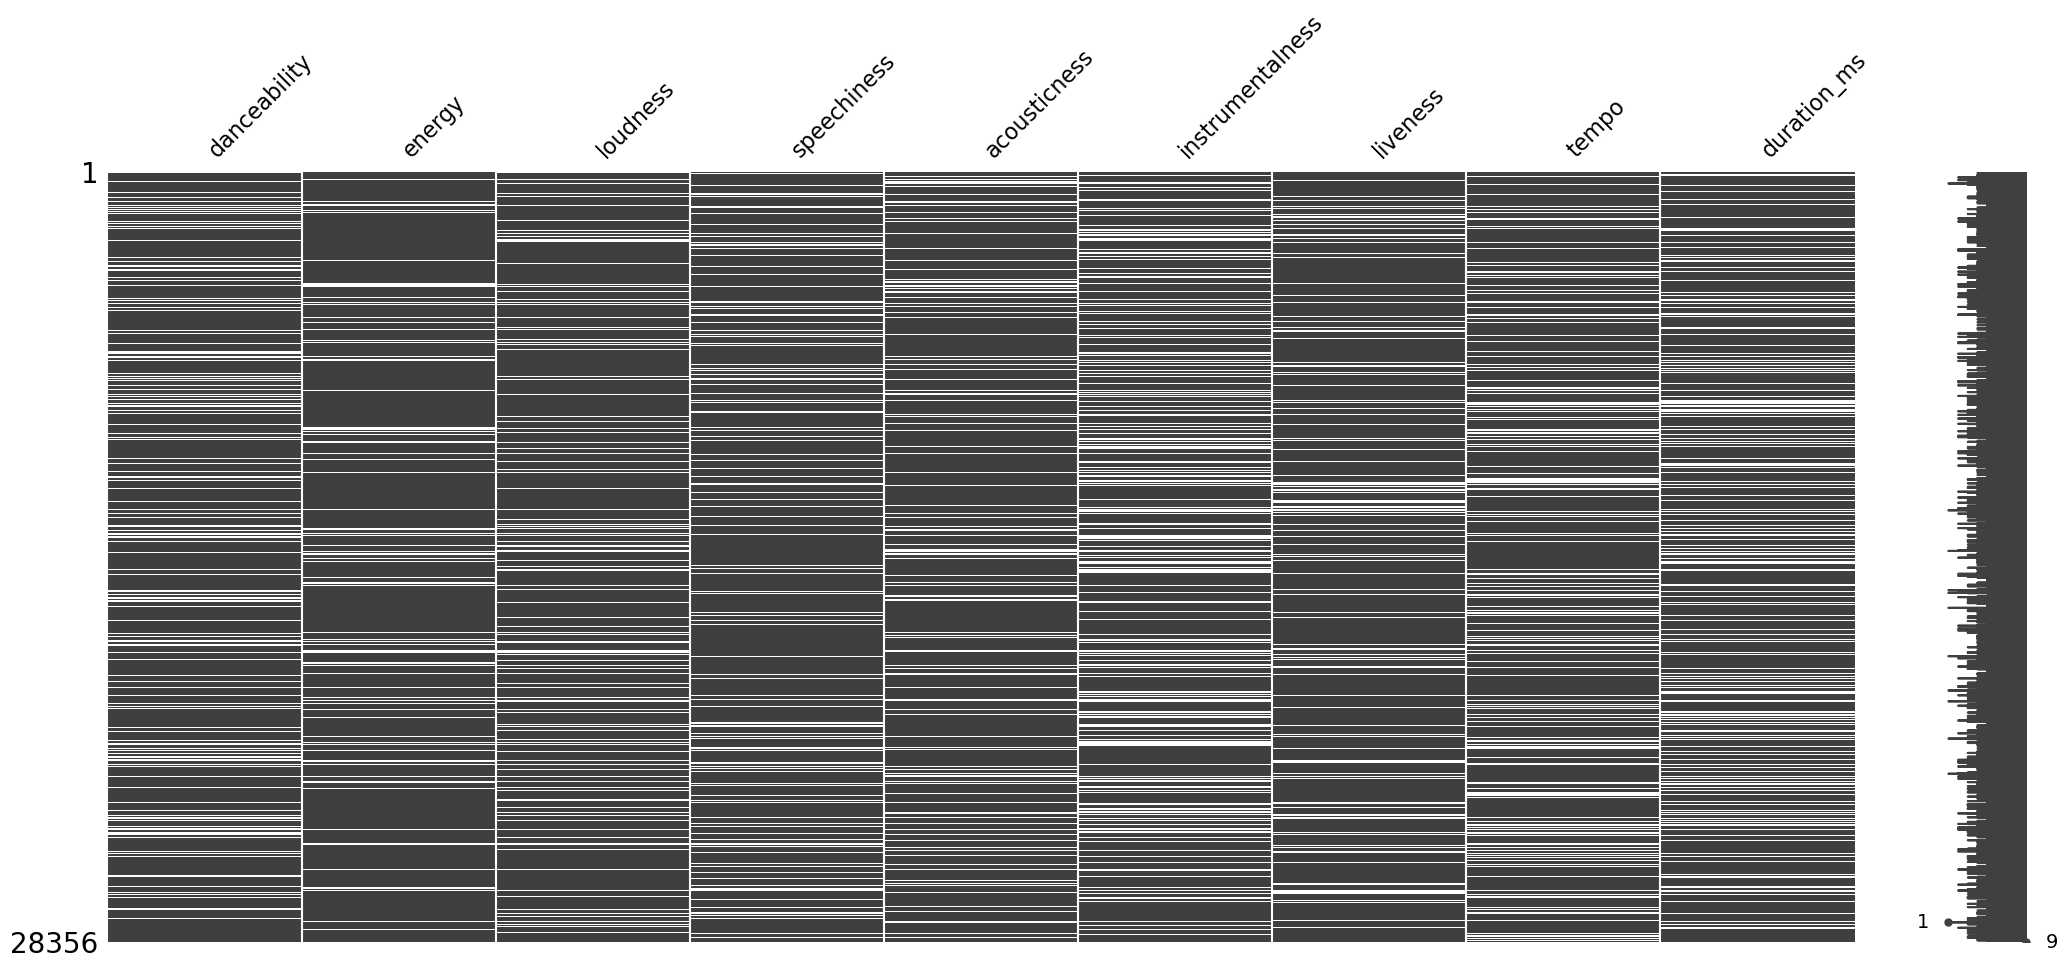

In [7]:
import missingno as msno

### plot the missingness (nullity) matrix
missingdata_df = df_num_nan.columns[df_num_nan.isnull().any()].tolist()
msno.matrix(df_num_nan[missingdata_df])
plt.show()

Another interesting thing to check is to see if there is a correlation between the missing values in each column. Meaning, if a missing value in a column A can indicate a missing value in column B:

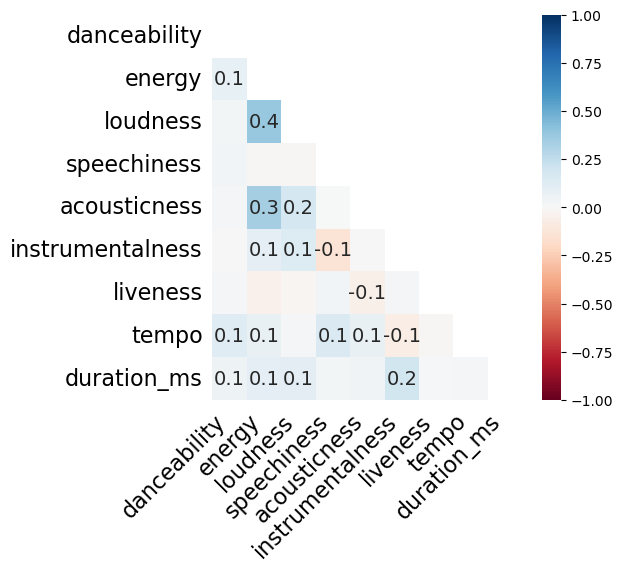

In [8]:
## missingness correlation heatmap

msno.heatmap(df_num_nan[missingdata_df], figsize=(5,5))
plt.show()

### Using MICE to impute missing values

In [9]:
import fancyimpute
df_num_mice = fancyimpute.IterativeImputer(max_iter=15).fit_transform(df_num_nan)
df_num_mice = pd.DataFrame(df_num_mice, columns=df_num_nan.columns)
df_num_mice.head(10)

,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,41.0,0.68200,0.475927,2.0,-10.068,0.023600,0.279000,0.000548,0.088700,0.566,97.091,235440.000000
1,15.0,0.58200,0.704000,5.0,-6.242,0.034700,0.065100,0.000000,0.212000,0.698,150.863,197286.000000
2,28.0,0.61656,0.880000,9.0,-4.739,0.044200,0.011700,0.000876,0.145307,0.404,135.225,215036.905676
3,24.0,0.65900,0.794000,10.0,-5.644,0.054000,0.000761,0.000599,0.322000,0.852,128.041,228565.000000
4,38.0,0.66200,0.838000,1.0,-6.300,0.049900,0.114000,0.000697,0.088100,0.496,129.884,236308.000000
5,12.0,0.83600,0.799000,7.0,-4.247,0.087300,0.187000,0.000000,0.092000,0.772,94.033,217653.000000
6,41.0,0.69130,0.616000,1.0,-8.747,0.058062,0.112745,0.000000,0.126999,0.716,145.461,219510.717176
7,52.0,0.76400,0.594000,6.0,-10.050,0.062445,0.144667,0.000000,0.145000,0.695,87.261,286441.000000
8,36.0,0.74300,0.860000,5.0,-6.346,0.044500,0.226000,0.000422,0.051300,0.687,102.459,259267.000000
9,42.0,0.57300,0.746000,10.0,-4.894,0.042100,0.024900,0.000000,0.145187,0.134,130.001,188000.000000


Lets see the status of missing values after applying MICE:

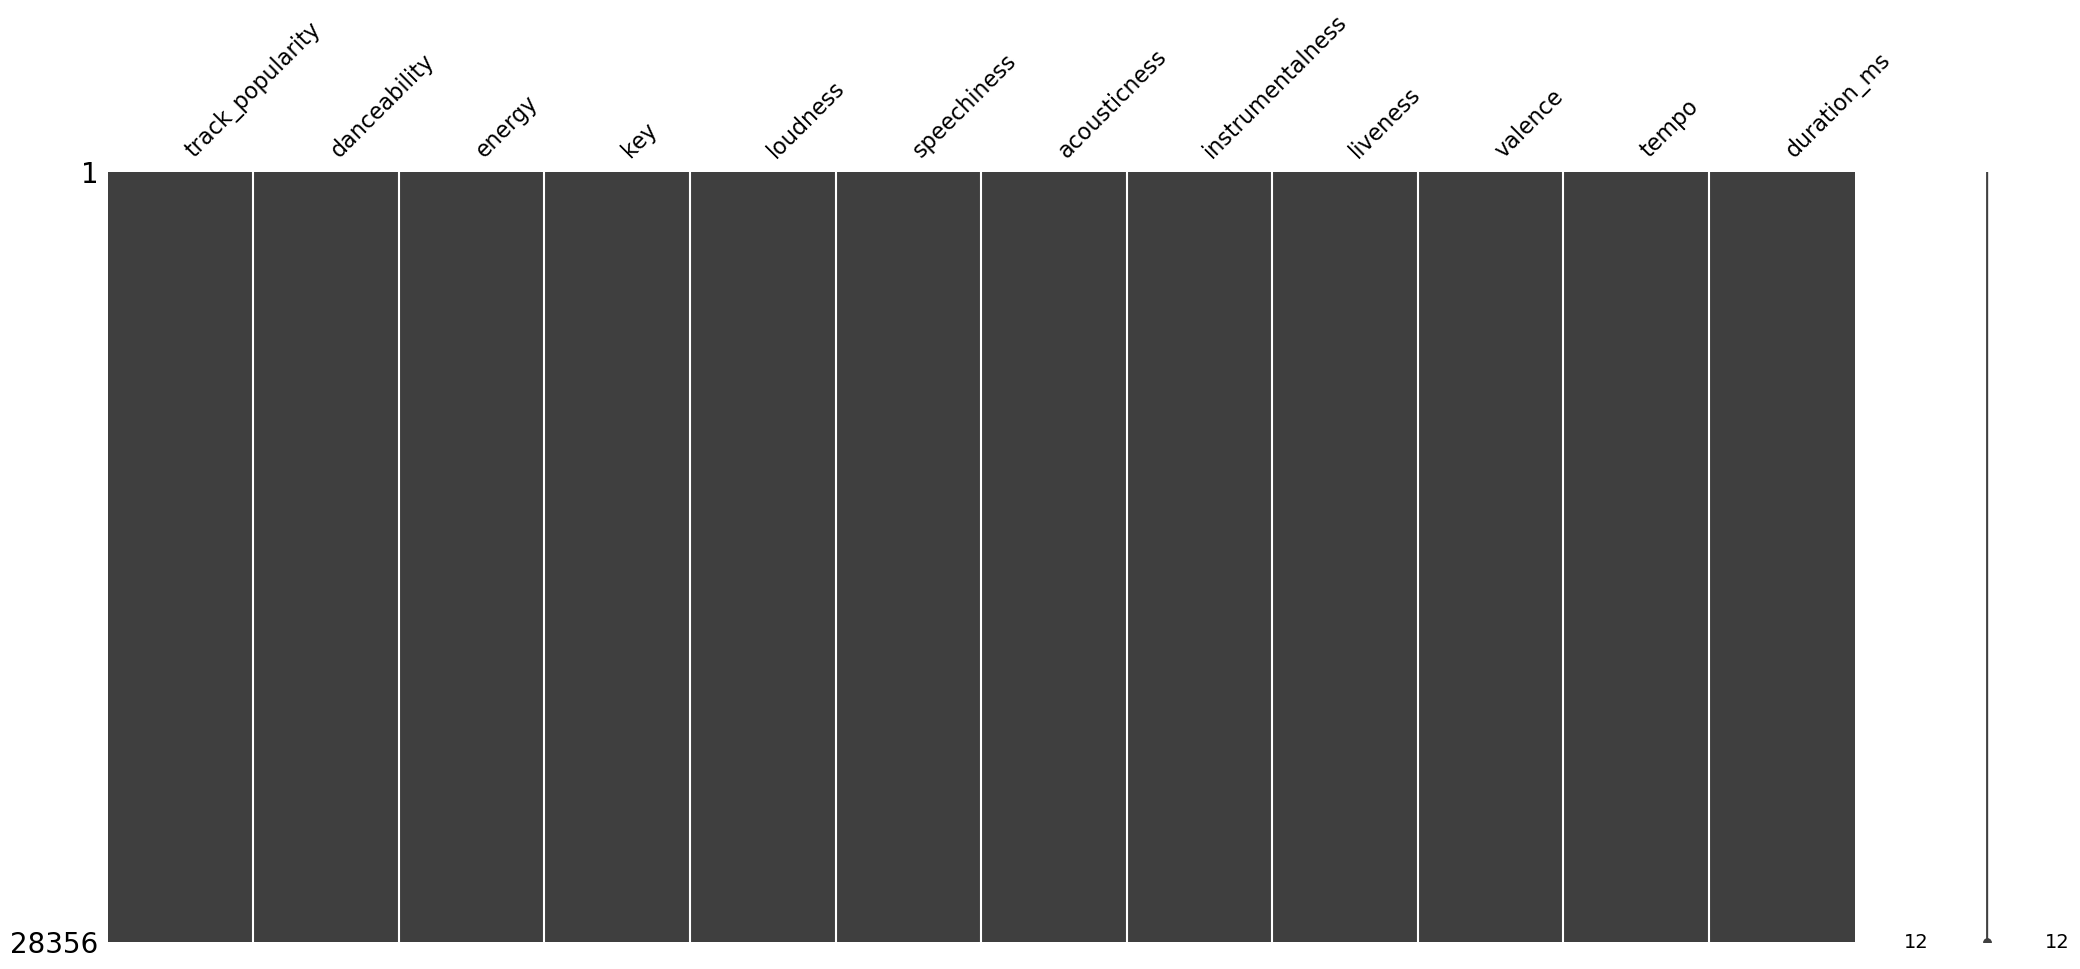

In [10]:
msno.matrix(df_num_mice)
plt.show()

In [11]:
df_num_mice.isnull().sum()

track_popularity    0
danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
dtype: int64

### Visualizing imputed values

Lets have some fun. Currently we have three data sets:

1. `df_num` - original dataframe with no missing values.
2. `df_num_nan` - dataframe with some of its values set to `np.nan`, due to being outlier values.
3. `df_num_mice` - no missing values because the MICE imputation technique was used to fill them from `df_num_nan`

Lets visualize this! I want to see the original distribution (with outliers), then the kept values (those who were inside the IQR based bounds), and the imputed data - all on the same plot.

Lets start with the `energy` column:

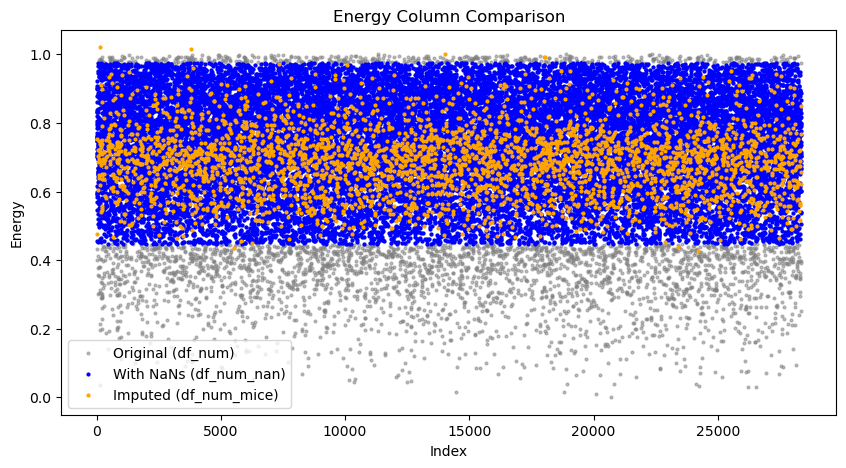

In [12]:
# Define the mask for imputed values (where df_num_nan had NaNs)
imputed_mask = df_num_nan["energy"].isna()

plt.figure(figsize=(10, 5))
dot_size = 4  # Smaller dots to reduce clutter

# Plot original values (grey, transparent)
plt.scatter(df_num.index, df_num["energy"], color='grey', alpha=0.5, s=dot_size, label="Original (df_num)")

# Plot df_num_nan values (blue)
plt.scatter(df_num_nan.index, df_num_nan["energy"], color='blue', s=dot_size, label="With NaNs (df_num_nan)")

# Plot only imputed values (orange)
plt.scatter(df_num.index[imputed_mask], df_num_mice.loc[imputed_mask, "energy"], 
            color='orange', s=dot_size, label="Imputed (df_num_mice)")

plt.xlabel("Index")
plt.ylabel("Energy")
plt.legend()
plt.title("Energy Column Comparison")

plt.show()


So cool. Lets fo this for each column in `df_num`:

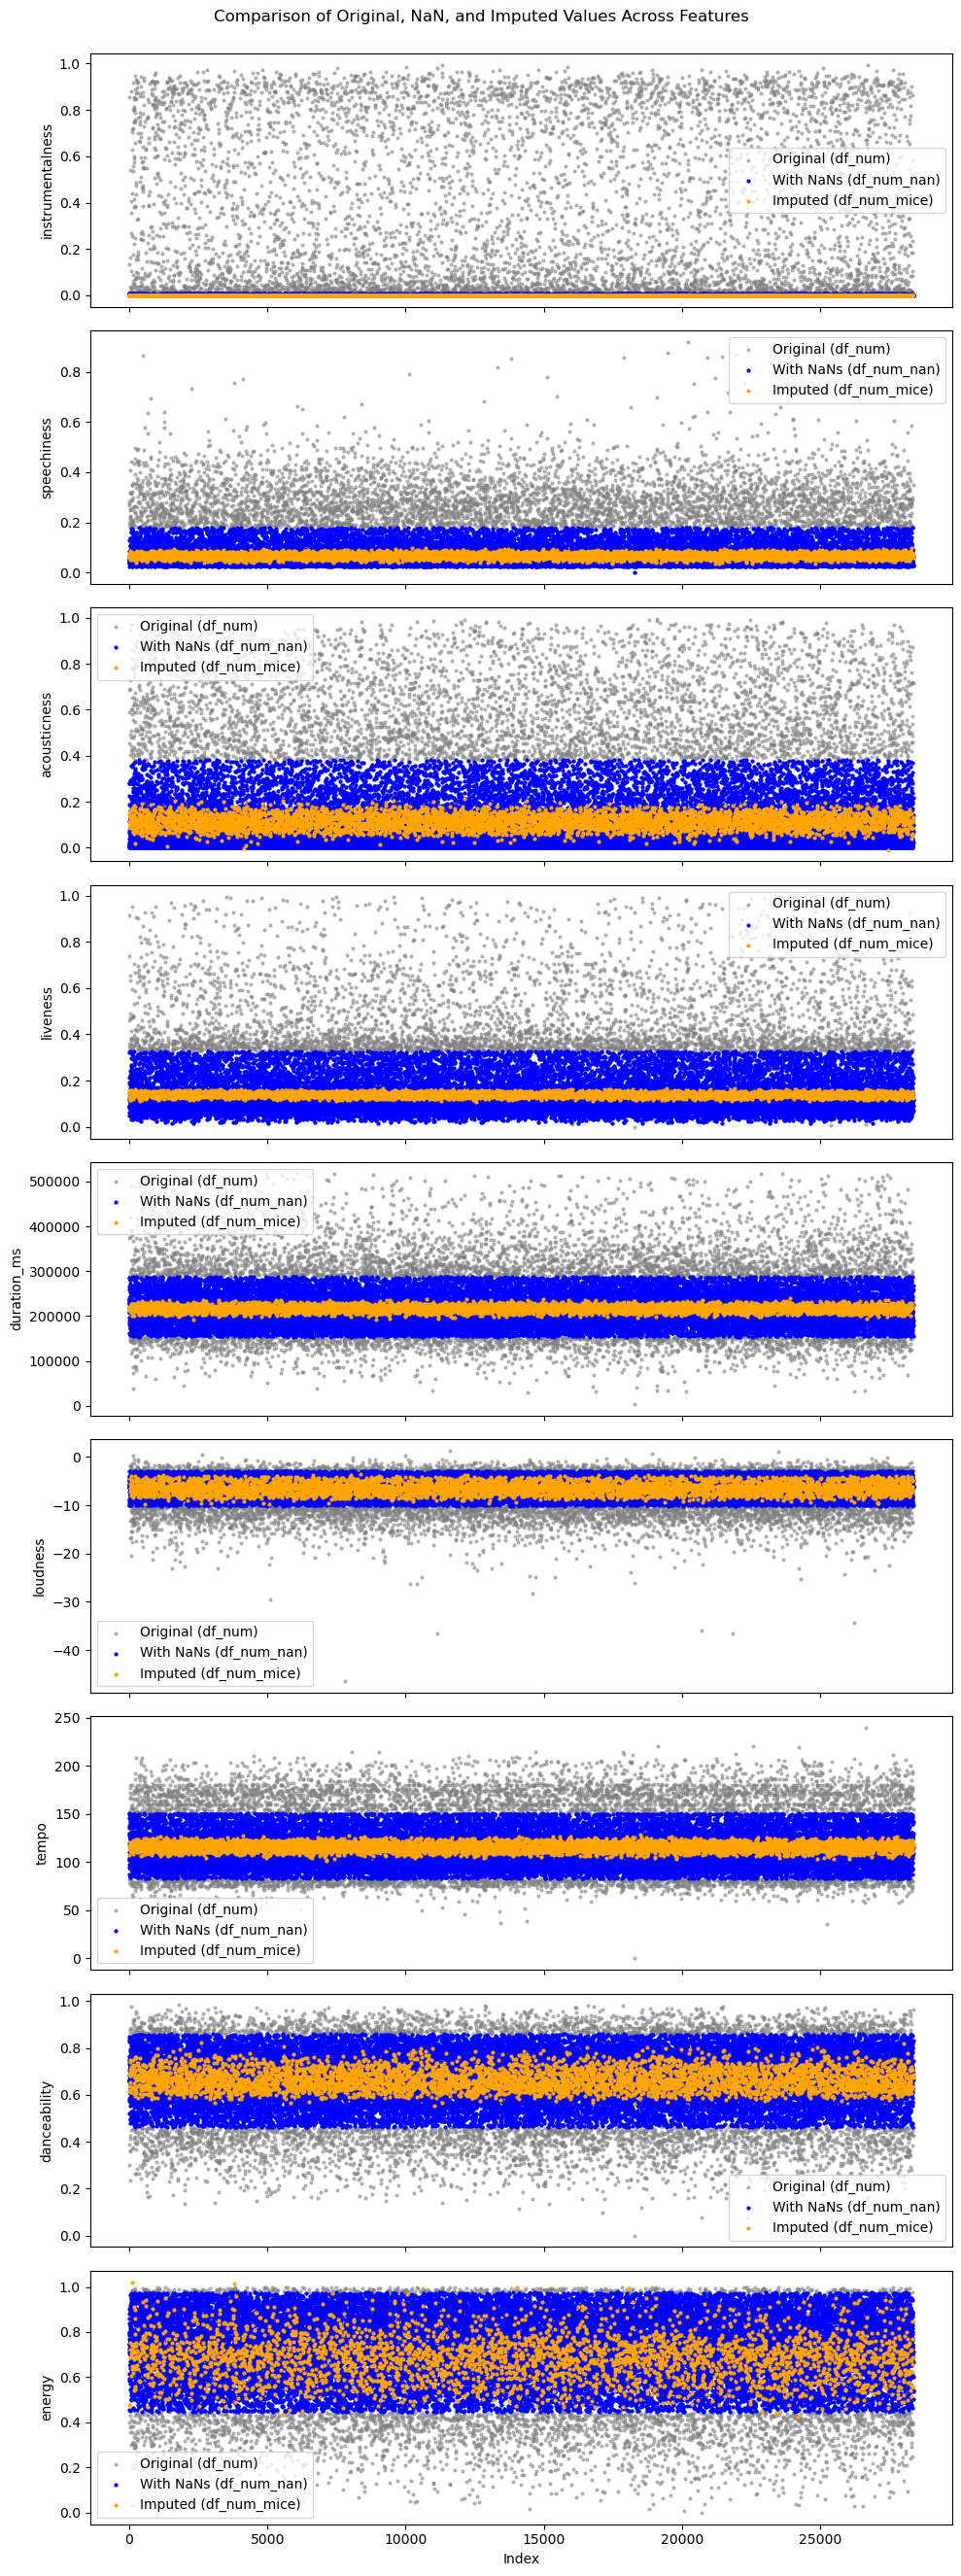

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# List of columns to visualize
columns = ["instrumentalness", "speechiness", "acousticness", "liveness", 
           "duration_ms", "loudness", "tempo", "danceability", "energy"]

num_cols = len(columns)

# Create subplots (adjusting the figure size dynamically)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, num_cols * 3), sharex=True)

dot_size = 4  # Smaller dots to reduce clutter

for ax, col in zip(axes, columns):
    # Identify the imputed values for the current column
    imputed_mask = df_num_nan[col].isna()

    # Plot original values (grey, transparent)
    ax.scatter(df_num.index, df_num[col], color='grey', alpha=0.5, s=dot_size, label="Original (df_num)")

    # Plot df_num_nan values (blue)
    ax.scatter(df_num_nan.index, df_num_nan[col], color='blue', s=dot_size, label="With NaNs (df_num_nan)")

    # Plot only imputed values (orange)
    ax.scatter(df_num.index[imputed_mask], df_num_mice.loc[imputed_mask, col], 
               color='orange', s=dot_size, label="Imputed (df_num_mice)")

    # Formatting
    ax.set_ylabel(col)
    ax.legend()

# Add common X label
axes[-1].set_xlabel("Index")

plt.suptitle("Comparison of Original, NaN, and Imputed Values Across Features")
plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to fit title
plt.show()


### Saving imputed data

Finally lets "merge" the imputed data back into the original dataframe, so we can use it in the next chapter!

In [14]:
df_final = df.copy()
for column in df_num_mice.columns:
    df_final[column] = df_num_mice[column]

df_final.head()

,track_id,track_artist,track_popularity,track_album_id,track_album_release_date,danceability,energy,key,loudness,mode,...,valence,tempo,duration_ms,playlist_count,edm,latin,pop,r&b,rap,rock
0,0017A6SJgTbfQVU2EtsPNo,Barbie's Cradle,41.0,1srJQ0njEQgd8w4XSqI4JQ,2001-01-01,0.68200,0.475927,2.0,-10.068,1,...,0.566,97.091,235440.000000,1,0,0,0,0,0,1
1,002xjHwzEx66OWFV2IP9dk,RIKA,15.0,1ficfUnZMaY1QkNp15Slzm,2018-01-26,0.58200,0.704000,5.0,-6.242,1,...,0.698,150.863,197286.000000,1,0,0,0,1,0,0
2,004s3t0ONYlzxII9PLgU6z,Steady Rollin,28.0,3z04Lb9Dsilqw68SHt6jLB,2017-11-21,0.61656,0.880000,9.0,-4.739,1,...,0.404,135.225,215036.905676,1,0,0,0,0,0,1
3,008MceT31RotUANsKuzy3L,The.madpix.project,24.0,1Z4ANBVuhTlS6DprlP0m1q,2015-08-07,0.65900,0.794000,10.0,-5.644,0,...,0.852,128.041,228565.000000,1,1,0,1,0,0,0
4,008rk8F6ZxspZT4bUlkIQG,YOSA & TAAR,38.0,2BuYm9UcKvI0ydXs5JKwt0,2018-11-16,0.66200,0.838000,1.0,-6.300,1,...,0.496,129.884,236308.000000,1,0,0,1,0,0,0


In [15]:
df_final.shape

(28356, 24)

### Handling missing artist names

A missing track artist name cannot be predicted sing regression model - however it does not need to.
In the next chapter Feature Engineering I will use label encoding for the artist name, so for now lets just fill missing names as an "Anonymous" artist. There are only four of those tracks with no artist, so it can be considered its own group in future encoding.

In [ ]:
df_final['track_artist'].fillna('Anonymous Artist', inplace=True)
df_final.head()

/tmp/ipykernel_13544/125457044.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['track_artist'].fillna('Anonymus Artist', inplace=True)


,track_id,track_artist,track_popularity,track_album_id,track_album_release_date,danceability,energy,key,loudness,mode,...,valence,tempo,duration_ms,playlist_count,edm,latin,pop,r&b,rap,rock
0,0017A6SJgTbfQVU2EtsPNo,Barbie's Cradle,41.0,1srJQ0njEQgd8w4XSqI4JQ,2001-01-01,0.68200,0.475927,2.0,-10.068,1,...,0.566,97.091,235440.000000,1,0,0,0,0,0,1
1,002xjHwzEx66OWFV2IP9dk,RIKA,15.0,1ficfUnZMaY1QkNp15Slzm,2018-01-26,0.58200,0.704000,5.0,-6.242,1,...,0.698,150.863,197286.000000,1,0,0,0,1,0,0
2,004s3t0ONYlzxII9PLgU6z,Steady Rollin,28.0,3z04Lb9Dsilqw68SHt6jLB,2017-11-21,0.61656,0.880000,9.0,-4.739,1,...,0.404,135.225,215036.905676,1,0,0,0,0,0,1
3,008MceT31RotUANsKuzy3L,The.madpix.project,24.0,1Z4ANBVuhTlS6DprlP0m1q,2015-08-07,0.65900,0.794000,10.0,-5.644,0,...,0.852,128.041,228565.000000,1,1,0,1,0,0,0
4,008rk8F6ZxspZT4bUlkIQG,YOSA & TAAR,38.0,2BuYm9UcKvI0ydXs5JKwt0,2018-11-16,0.66200,0.838000,1.0,-6.300,1,...,0.496,129.884,236308.000000,1,0,0,1,0,0,0


In [18]:
null_values = df_final.isnull().sum()
print(null_values)


track_id                    0
track_artist                0
track_popularity            0
track_album_id              0
track_album_release_date    0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
playlist_count              0
edm                         0
latin                       0
pop                         0
r&b                         0
rap                         0
rock                        0
dtype: int64


## Save as pickle and csv

We finished the data preparation part! It is time to store the df as a pickle file for the next chapter :-)

In [20]:
df.to_pickle('pickle/03_data_cleansing/data_data_cleansing.pkl')

In [22]:
df.to_csv('data/03_data_cleansing/data_cleansing.csv')

### Processed Dataset Overview

In [23]:
display(df.shape)

df.info()

(28356, 24)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   track_id                  28356 non-null  object        
 1   track_artist              28352 non-null  object        
 2   track_popularity          28356 non-null  int64         
 3   track_album_id            28356 non-null  object        
 4   track_album_release_date  28356 non-null  datetime64[ns]
 5   danceability              28356 non-null  float64       
 6   energy                    28356 non-null  float64       
 7   key                       28356 non-null  int64         
 8   loudness                  28356 non-null  float64       
 9   mode                      28356 non-null  int64         
 10  speechiness               28356 non-null  float64       
 11  acousticness              28356 non-null  float64       
 12  instrumentalness  

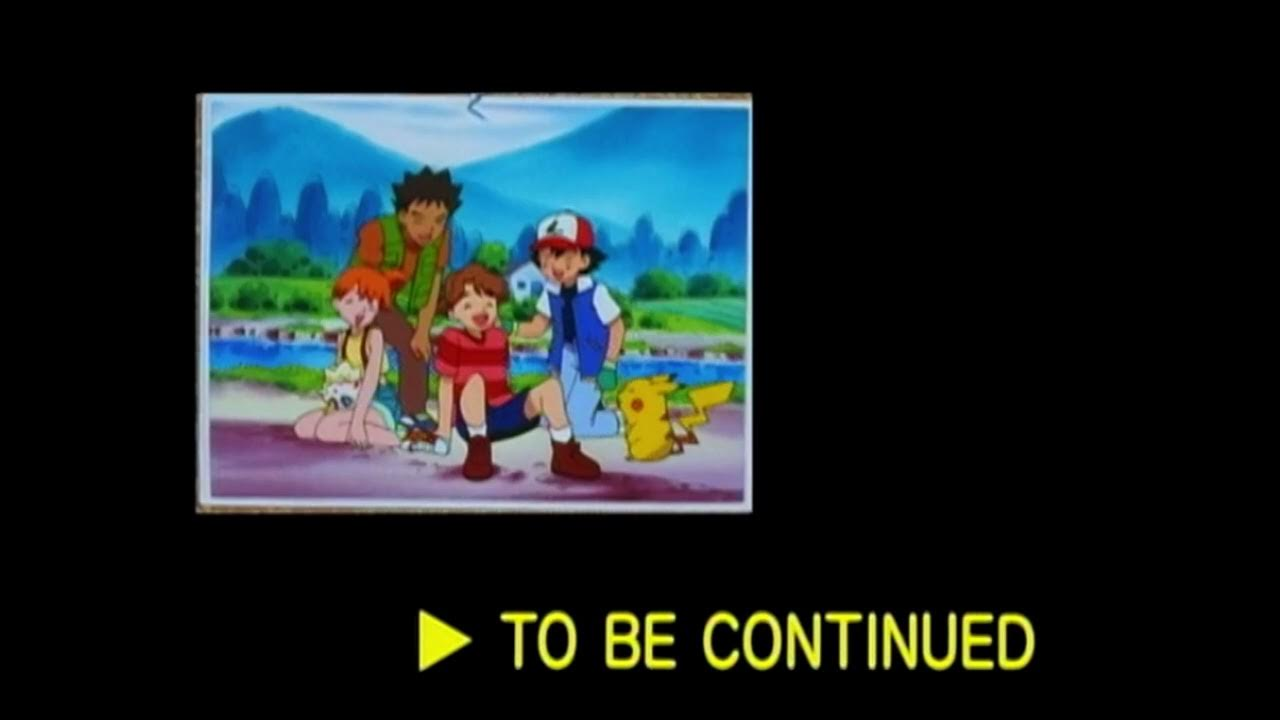